In [1]:
import warnings
warnings.filterwarnings('ignore')

# Underthesea - A Vietnamese NLP toolkit
!pip install underthesea > /dev/null 2>&1 # not print the pip installation
import underthesea
from underthesea import word_tokenize
from underthesea import text_normalize
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import wordcloud
import regex as re
import string
import random
import nltk
from inspect import signature

In [2]:
def remove_emoji(text):
    text = text.lower() # chuyển về chữ thường
    # Biểu thức chính quy để tìm và loại bỏ emoji
    emoji_pattern = re.compile(
        "[\U0001F600-\U0001F64F"  # emoticons
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U00002500-\U00002BEF"  # chinese char
        "\U00002702-\U000027B0"
        "\U00002702-\U000027B0"
        "\U000024C2-\U0001F251"
        "\U0001f926-\U0001f937"
        "\U00010000-\U0010FFFF"
        "\u2640-\u2642"
        "\u2600-\u2B55"
        "\u200d"
        "\u23cf"
        "\u23e9"
        "\u231a"
        "\ufe0f"  # dingbats
        "\u3030]+", flags=re.UNICODE
    )
    return emoji_pattern.sub(r'', text)


In [3]:
def separate_number_and_text(text):
    # Tách chữ và số khi chúng ở cạnh nhau
    text = re.sub(r'(\d)([a-zA-Z])', r'\1 \2', text)  # số + chữ
    text = re.sub(r'([a-zA-Z])(\d)', r'\1 \2', text)  # chữ + số
    return text

In [4]:
def clean_text(text):
    # Xóa ký tự <3
    text = re.sub(r'<3', '', text)

    text = re.sub(r'([a-z]+?)\1+',r'\1', text) # reduce repeated character (e.g. 'aaabbb' -> 'ab')

    # Thêm khoảng trắng trước và sau dấu câu
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])\s*(\w)", r"\1 \2 \3", text)
    text = re.sub(r"(\w)\s*([" + string.punctuation + "])", r"\1 \2", text)

    text = re.sub(f"([{string.punctuation}])([{string.punctuation}])+", r"\1", text)  # Giảm dấu câu liên tiếp

    # Loại bỏ dấu câu và khoảng trắng đầu/cuối
    text = text.strip()
    while text.endswith(tuple(string.punctuation + string.whitespace)):
        text = text[:-1]
    while text.startswith(tuple(string.punctuation + string.whitespace)):
        text = text[1:]

    # Loại bỏ tất cả dấu câu
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\w\s/]', ' ', text)

    # Giảm khoảng trắng thừa
    text = re.sub(r"\s+", " ", text)
    return text

In [5]:
def remove_dates_and_times(text):
    # Loại bỏ định dạng dd/mm/yyyy, d/m/yyyy, dd-mm-yyyy, d-m-yyyy
    text = re.sub(r'\b\d{1,2}([\/:-])\d{1,2}\1\d{4}\b', '', text)

    # Loại bỏ định dạng yyyy
    text = re.sub(r'\b\d{4}\b', '', text)

    # Loại bỏ giờ phút giây với các định dạng hh:mm hoặc hh:mm:ss
    text = re.sub(r'\b\d{1,2}(:)\d{2}(:\d{2})?\b', '', text)

    # Loại bỏ định dạng ngày tháng năm d/m/yyyy, dd/mm/yyyy, d/m/yy, dd/mm/yy
    text = re.sub(r'\b\d{1,2}([\/:-])\d{1,2}\1\d{2,4}\b', '', text)  # dd/mm/yy, d/m/yy

    # Loại bỏ định dạng d.m.yyyy, dd.mm.yyyy
    text = re.sub(r'\b\d{1,2}([.])\d{1,2}\1\d{2,4}\b', '', text)

    # Loại bỏ định dạng d/m hoặc dd/mm
    text = re.sub(r'\b\d{1,2}([\/])\d{1,2}\b', '', text)

    # Loại bỏ khoảng trắng thừa sau khi xóa
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [6]:
abbreviation_map = {
    "nữa": "nx",
    "ạ": "ạ",
    "anh":["a","ah"],
    "anh chị em": "ace",
    "ý": "í",
    "không": ["ko", "k", "kh", "kok","khôg","khong","0","dell","đéo","hong","éo"],
    "cần": "cần",
    "gì": ["j", "ji"],
    "với": "vs",
    "như thế nào": "ntn",
    "à": "ak",
    "á": ["ák", "áh"],
    "nước": "nc",
    "bình thường": ["bth", "bthuong"],
    "xúc": "súc",
    "giờ": "h",
    "mọi người": ["mn", "m n", "mng", "m ng", "mg", "ng", "m.ng"],
    "rất": ["rat","gất"],
    "vui": "zui",
    "cũng": ["cx","củg"],
    "xuất sắc": "xs",
    "tôi": ["t","tui"],
    "phim": ["fim", "film"],
    "thích": ["thik","thix"],
    "vị": "zị",
    "vậy": ["z", "vay", "zay","v","zayj"],
    "mình": ["mih", "mk", "mik", "mjk"],
    "khóc": ["khok", "khók", "khoc"],
    "mới": "ms",
    "xem": "coi",
    "biết": ["bt","bik"],
    "gia đình": ["gđ", "gd"],
    "làm": "lm",
    "được": ["dc","đc","đk"],
    "đã":["dx","đx"],
    "quảng cáo": ["qc","pr"],
    "quần què": "qq",
    "trời": "tr",
    "em": "e",
    "bộ": "bọ",
    "điện thoại": "đt",
    "cười": "cừi",
    "rồi": ["r","gòi"],
    "rơi": "roi",
    "quá": ["wa","quad","qá"],
    "cuộc sống": ["cs", "csong"],
    "sản xuất": "sx",
    "tào lao": "tào nao",
    "nói": ["ns","nố"],
    "thì": "thig",
    "đang": ["đg","dang"],
    "trước": ["trc","trk"],
    "càng hay": "càn hay",
    "cần":"càn",
    "thôi": "thoi",
    "nhân vật": "nv",
    "diễn viên": "dv",
    "nhưng mà": ["nhma", "nhgma","nma"],
    "nhưng": ["nhg","nhx"],
    "truyền hình Việt Nam": "thvn",
    "phỏng vấn": "pv",
    "Việt Nam": ["vietnam","vn"],
    "lắm": "vch",
    "thương": "thw",
    "như": ["nhu","nhw"],
    "luôn": ["un", "lun"],
    "đi": ["ik", "jk"],
    "còn": "kon",
    "youtube": "yt",
    "hiểu": "hỉu",
    "người ta": "ngta",
    "sài gòn": "sg",
    "thằng": "tg",
    "hoài": "qài",
    "ý nghĩa":"y nghĩa",
    "tình cảm":"tc",
    "yêu": ["love","lỏve","iu"],
    "ác":"ắc",
    "rất hay":["very god","very good","verygood"],
    "sự":"su",
    "suy ngẫm": "suy ngâm",
    "vào":"zô",
    "chính":"trính",
    "nhiều":"nhìu",
    "ở": "ỡ",
    "xui":"xuoi",
    "tuyệt vời":"toẹt zời",
    "động":"độg",
    "thú vị":"thú zị",
    "tiếng": "tieng",
    "phải": "pải",
    "tình yêu": "ty",
    "mẹ đơn thân": ["sgm","single mom"],
    "chia tay": "chia tay",
    "trai":"zai",
    "hạnh phúc":["hp","hphuc"],
    "người khác":"ngkhac",
    "phải không": "pk",
    "chuyện":"chz",
    "bác sĩ": "bsi",
    "điện ảnh": "đ/ảnh",
    "nhận xét": ["review","nxet","rv"],
    "quảng cáo": "pr",

}

def apply_full_text(text):
    # Duyệt qua từng từ viết tắt và thay thế bằng từ đầy đủ
    for full_word, abbreviation in abbreviation_map.items():
        # Nếu từ viết tắt là một danh sách các từ, thay thế tất cả
        if isinstance(abbreviation, list):
            for abbr in abbreviation:
                text = re.sub(r'\b' + re.escape(abbr) + r'\b', full_word, text)
        else:
            # Nếu từ viết tắt là một từ đơn, thay thế trực tiếp
            text = re.sub(r'\b' + re.escape(abbreviation) + r'\b', full_word, text)

    return text

In [7]:
stop_words = [
    "bị", "bởi", "cả", "các", "cái", "cần", "càng", "chỉ", "chiếc", "cho", "chưa", "chuyện",
    "có", "cứ", "của", "cùng", "cũng", "đã", "đang", "đây", "để", "đến_nỗi", "đều",
    "điều", "do", "đó", "được", "dưới", "gì", "khi", "không", "là", "lại", "lên", "lúc", "mà",
    "mỗi", "này", "nên", "nếu", "ngay", "nhiều", "như", "nhưng", "những", "nơi",
    "nữa", "phải", "qua", "ra", "rằng", "rất", "rồi", "sau", "sẽ", "so", "sự", "tại", "theo",
    "thì", "trên", "trước", "từ", "từng", "và", "vẫn", "vào", "vậy", "về", "việc", "với", "vừa","ủa",
    "à", "ừ", "nhé", "ạ","á","mà","ha","hm"
]

def remove_stop_words(text, stop_words):
    # Chia văn bản thành các từ
    words = text.split()

    # Loại bỏ các từ dừng (stop words)
    cleaned_text = " ".join([word for word in words if word not in stop_words])

    return cleaned_text


In [8]:
df1= pd.read_csv('/kaggle/input/data-comment/Data/phim_bo_gia_label.csv')
df2 = pd.read_csv('/kaggle/input/data-comment/Data/Phim_NBN_label.csv')
df3 = pd.read_csv('/kaggle/input/data-comment/Data/class123.csv')
df4 = pd.read_csv('/kaggle/input/data-comment/Data/comments_class123.csv')
df5 = pd.read_csv('/kaggle/input/data-comment/Data/all_comments - all_comments.csv')

In [9]:
df_all = pd.concat([df1, df2, df3,df4,df5], ignore_index=True)
df_all

,text,label
0,…. với một fim rất là tâm lý xã hội đã lấy nướ...,5
1,@__chúc mừng e trấn Thành Bộ phim tc cảm động...,5
2,<3 Cảm ơn những bộ phim hay và ý nghĩa,5
3,❤ phim rất hay chân thật và đời thường. Rất cả...,5
4,❤❤❤❤❤🎉🎉 nhưng người cha chững tính lại chút nữ...,4
...,...,...
32476,NaN,NaN
32477,thật là phi diệu,3
32478,Top1 thẳng tiến!!!,4
32479,NaN,NaN


In [10]:
df_all = df_all.drop_duplicates()

In [11]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20859 entries, 0 to 32480
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20852 non-null  object
 1   label   13503 non-null  object
dtypes: object(2)
memory usage: 488.9+ KB


In [12]:
df_all = df_all[df_all["label"].astype(str).str.match(r'^[1-5]$')]

In [13]:
df_all = df_all.dropna(subset=['text'])  # Xóa NaN

In [14]:
df_all["text"] = df_all["text"].astype(str)

In [15]:
df_all['remove_emoji'] = df_all['text'].apply(remove_emoji)

In [16]:
df_all

,text,label,remove_emoji
0,…. với một fim rất là tâm lý xã hội đã lấy nướ...,5,…. với một fim rất là tâm lý xã hội đã lấy nướ...
1,@__chúc mừng e trấn Thành Bộ phim tc cảm động...,5,@__chúc mừng e trấn thành bộ phim tc cảm động...
2,<3 Cảm ơn những bộ phim hay và ý nghĩa,5,<3 cảm ơn những bộ phim hay và ý nghĩa
3,❤ phim rất hay chân thật và đời thường. Rất cả...,5,phim rất hay chân thật và đời thường. rất cảm...
4,❤❤❤❤❤🎉🎉 nhưng người cha chững tính lại chút nữ...,4,nhưng người cha chững tính lại chút nữa thì c...
...,...,...,...
32472,Chúc phim thành công được nhiều người yêu mến ...,3,chúc phim thành công được nhiều người yêu mến ...
32474,mình mới xem qua galaxy play rất là hay ngồi c...,5,mình mới xem qua galaxy play rất là hay ngồi c...
32477,thật là phi diệu,3,thật là phi diệu
32478,Top1 thẳng tiến!!!,4,top1 thẳng tiến!!!


In [20]:
df_all['remove_emoji'] = df_all['remove_emoji'].apply(separate_number_and_text)

In [21]:
df_all['clean_0'] = df_all['remove_emoji'].apply(remove_dates_and_times)

In [22]:
df_all

,text,label,remove_emoji,clean_0
0,…. với một fim rất là tâm lý xã hội đã lấy nướ...,5,…. với một fim rất là tâm lý xã hội đã lấy nướ...,…. với một fim rất là tâm lý xã hội đã lấy nướ...
1,@__chúc mừng e trấn Thành Bộ phim tc cảm động...,5,@__chúc mừng e trấn thành bộ phim tc cảm động...,@__chúc mừng e trấn thành bộ phim tc cảm động ...
2,<3 Cảm ơn những bộ phim hay và ý nghĩa,5,<3 cảm ơn những bộ phim hay và ý nghĩa,<3 cảm ơn những bộ phim hay và ý nghĩa
3,❤ phim rất hay chân thật và đời thường. Rất cả...,5,phim rất hay chân thật và đời thường. rất cảm...,phim rất hay chân thật và đời thường. rất cảm ...
4,❤❤❤❤❤🎉🎉 nhưng người cha chững tính lại chút nữ...,4,nhưng người cha chững tính lại chút nữa thì c...,nhưng người cha chững tính lại chút nữa thì cà...
...,...,...,...,...
32472,Chúc phim thành công được nhiều người yêu mến ...,3,chúc phim thành công được nhiều người yêu mến ...,chúc phim thành công được nhiều người yêu mến ...
32474,mình mới xem qua galaxy play rất là hay ngồi c...,5,mình mới xem qua galaxy play rất là hay ngồi c...,mình mới xem qua galaxy play rất là hay ngồi c...
32477,thật là phi diệu,3,thật là phi diệu,thật là phi diệu
32478,Top1 thẳng tiến!!!,4,top 1 thẳng tiến!!!,top 1 thẳng tiến!!!


In [23]:
df_all['clean_0'] = df_all['clean_0'].apply(clean_text)

In [24]:
df_all.drop('remove_emoji', axis=1, inplace=True)
df_all

,text,label,clean_0
0,…. với một fim rất là tâm lý xã hội đã lấy nướ...,5,với một fim rất là tâm lý xã hội đã lấy nước ...
1,@__chúc mừng e trấn Thành Bộ phim tc cảm động...,5,chúc mừng e trấn thành bộ phim tc cảm động nhi...
2,<3 Cảm ơn những bộ phim hay và ý nghĩa,5,cảm ơn những bộ phim hay và ý nghĩa
3,❤ phim rất hay chân thật và đời thường. Rất cả...,5,phim rất hay chân thật và đời thường rất cảm đ...
4,❤❤❤❤❤🎉🎉 nhưng người cha chững tính lại chút nữ...,4,nhưng người cha chững tính lại chút nữa thì cà...
...,...,...,...
32472,Chúc phim thành công được nhiều người yêu mến ...,3,chúc phim thành công được nhiều người yêu mến ...
32474,mình mới xem qua galaxy play rất là hay ngồi c...,5,mình mới xem qua galaxy play rất là hay ngồi c...
32477,thật là phi diệu,3,thật là phi diệu
32478,Top1 thẳng tiến!!!,4,top 1 thẳng tiến


In [25]:
df_all['clean_1']= df_all['clean_0'].apply(apply_full_text)

In [26]:
df_all.drop('clean_0', axis=1, inplace=True)

In [27]:
df_all['clean_text'] = df_all['clean_1'].apply(lambda x: remove_stop_words(x, stop_words))
df_all

,text,label,clean_1,clean_text
0,…. với một fim rất là tâm lý xã hội đã lấy nướ...,5,với một phim rất là tâm lý xã hội đã lấy nước...,một phim tâm lý xã hội lấy nước mắt tôi lần mặ...
1,@__chúc mừng e trấn Thành Bộ phim tc cảm động...,5,chúc mừng em trấn thành bộ phim tình cảm cảm đ...,chúc mừng em trấn thành bộ phim tình cảm cảm đ...
2,<3 Cảm ơn những bộ phim hay và ý nghĩa,5,cảm ơn những bộ phim hay và ý nghĩa,cảm ơn bộ phim hay ý nghĩa
3,❤ phim rất hay chân thật và đời thường. Rất cả...,5,phim rất hay chân thật và đời thường rất cảm đ...,phim hay chân thật đời thường cảm động trấn th...
4,❤❤❤❤❤🎉🎉 nhưng người cha chững tính lại chút nữ...,4,nhưng người cha chững tính lại chút nữa thì cầ...,người cha chững tính chút hay
...,...,...,...,...
32472,Chúc phim thành công được nhiều người yêu mến ...,3,chúc phim thành công được nhiều người yêu mến ...,chúc phim thành công người yêu mến chúc mọi ng...
32474,mình mới xem qua galaxy play rất là hay ngồi c...,5,mình mới xem qua galaxy play rất là hay ngồi c...,mình mới xem galaxy play hay ngồi cười muốn bể...
32477,thật là phi diệu,3,thật là phi diệu,thật phi diệu
32478,Top1 thẳng tiến!!!,4,top 1 thẳng tiến,top 1 thẳng tiến


In [28]:
df_all['label'] = df_all['label'].astype(int)

In [29]:
df_all = df_all.drop_duplicates()
df_all = df_all[["clean_text","label"]]

In [30]:
df_all["label"] = df_all["label"].astype(int)
df_all["label"] = df_all["label"] - 1

In [34]:
df_all

,clean_text,label
0,một phim tâm lý xã hội lấy nước mắt tôi lần mặ...,4
1,chúc mừng em trấn thành bộ phim tình cảm cảm đ...,4
2,cảm ơn bộ phim hay ý nghĩa,4
3,phim hay chân thật đời thường cảm động trấn th...,4
4,người cha chững tính chút hay,3
...,...,...
32472,chúc phim thành công người yêu mến chúc mọi ng...,2
32474,mình mới xem galaxy play hay ngồi cười muốn bể...,4
32477,thật phi diệu,2
32478,top 1 thẳng tiến,3


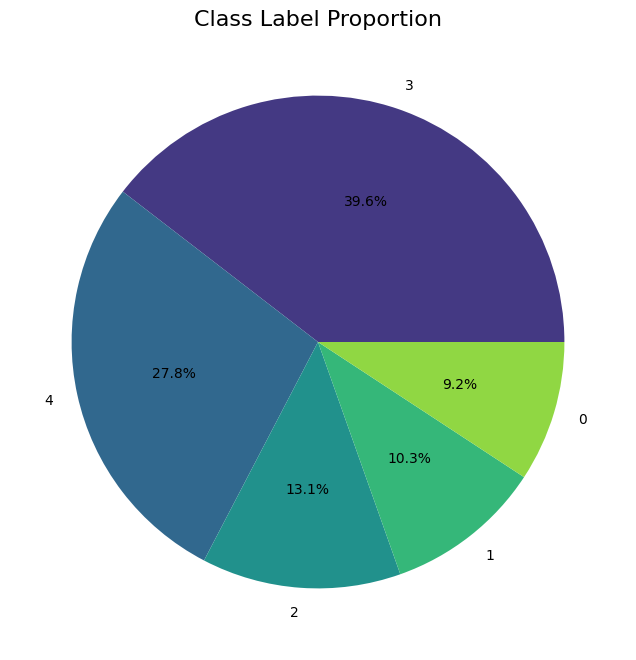

In [32]:
# Đếm số lượng mẫu cho mỗi lớp
label_counts = df_all['label'].value_counts()
# Vẽ biểu đồ tròn
plt.figure(figsize=(8, 8))
plt.pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(label_counts)))
plt.title('Class Label Proportion', fontsize=16)
plt.show()

In [35]:
def nor_tokenzie(text):
  text = text_normalize(text) # Chuẩn hóa văn bản để đảm bảo các dấu câu, dấu thanh, và ký tự trong văn bản đúng chuẩn tiếng Việt.
  text = word_tokenize(text, format="text") # token hóa  (tách từ) trên văn bản sau khi đã chuẩn hóa
  return text

In [38]:
df_t = df_all['clean_text'].apply(nor_tokenzie)

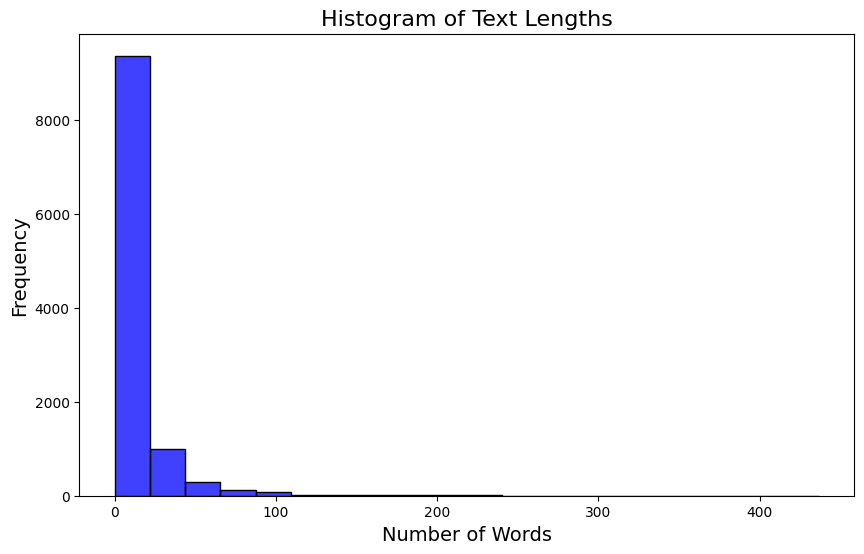

In [39]:
# Vẽ histogram
hist = df_t.apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(hist, bins=20, color='blue')
plt.title('Histogram of Text Lengths', fontsize=16)
plt.xlabel('Number of Words', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.show()


In [40]:
!pip install -q datasets
!pip install -q pytorch-lightning
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.1 MB/s eta 0:00:00


In [41]:
from transformers import AutoTokenizer
import torch
from datasets import Dataset, DatasetDict
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback

from evaluate import load

In [47]:
import torch.nn as nn

In [42]:
# Xác định thiết bị (GPU nếu có, nếu không thì dùng CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [143]:
# Tải tokenizer của PhoBERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [44]:
# Hàm tokenize dữ liệu
def preprocess_function(examples):
    return tokenizer(examples["clean_text"], padding="max_length", truncation=True, max_length=256)

In [141]:
df_all['label'] = df_all['label'].replace(4, 3)

In [144]:
# Chuyển Pandas DataFrame thành Hugging Face Dataset
dataset = Dataset.from_pandas(df_all)

# Chia dữ liệu train/test
dataset = dataset.train_test_split(test_size=0.3)

# Tokenize dữ liệu
dataset = dataset.map(preprocess_function, batched=True)

# Định dạng lại dataset
dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])


Map:   0%|          | 0/8744 [00:00<?, ? examples/s]

Map:   0%|          | 0/2186 [00:00<?, ? examples/s]

In [150]:
class PhoBERTWithDropout(nn.Module):
    def __init__(self, model_name, num_labels, dropout_rate=0.3):
        super(PhoBERTWithDropout, self).__init__()
        self.phobert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
        self.dropout = nn.Dropout(dropout_rate)  # Thêm Dropout
        self.classifier = self.phobert.classifier  

    def forward(self, input_ids, attention_mask=None, labels=None):
        outputs = self.phobert(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return outputs  # Trả về toàn bộ outputs để giữ nguyên định dạng gốc



In [151]:
# Khởi tạo model với dropout 0.3
model = PhoBERTWithDropout("vinai/phobert-base", num_labels=4, dropout_rate=0.3)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [146]:
# Kiểm tra dataset trước khi huấn luyện
print(dataset)
print(dataset["train"][0])  # In thử 1 sample


DatasetDict({
    train: Dataset({
        features: ['clean_text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 8744
    })
    test: Dataset({
        features: ['clean_text', 'label', '__index_level_0__', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2186
    })
})
{'label': tensor(2), 'input_ids': tensor([    0,    68,  1981,  6987,  1021,    18,   759,  7927,  1283,    12,
          110,   235,   733,   311,  4263, 11796,   423,   364,   108,    68,
           12,   266,   364,   108,  1440,  1362,    68,   266,     2,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1

In [147]:
# Load metric accuracy từ thư viện evaluate
metric = load("accuracy")

# Hàm tính accuracy
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)  # Chọn class có xác suất cao nhất
    return metric.compute(predictions=predictions, references=labels)


In [152]:
training_args = TrainingArguments(
    output_dir="./checkpoints",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_safetensors=False, 
    learning_rate=5e-5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    load_best_model_at_end=True, 
    
)


In [149]:
# List để lưu kết quả từng epoch
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

class TrainLogCallback(TrainerCallback):
    def on_epoch_end(self, args, state, control, **kwargs):
        # Đánh giá trên tập train & validation
        train_metrics = trainer.evaluate(eval_dataset=dataset["train"])
        val_metrics = trainer.evaluate(eval_dataset=dataset["test"])

        # Lưu lại kết quả
        history["train_loss"].append(train_metrics["eval_loss"])
        history["train_acc"].append(train_metrics["eval_accuracy"])
        history["val_loss"].append(val_metrics["eval_loss"])
        history["val_acc"].append(val_metrics["eval_accuracy"])

        # In log ra console
        print(f"\nEpoch {int(state.epoch)}:")
        print(f"  Train Loss: {train_metrics['eval_loss']:.4f} | Train Acc: {train_metrics['eval_accuracy']:.4f}")
        print(f"  Val Loss  : {val_metrics['eval_loss']:.4f} | Val Acc  : {val_metrics['eval_accuracy']:.4f}")

        # Log vào Trainer
        trainer.log({
            "train_loss": train_metrics["eval_loss"],
            "train_accuracy": train_metrics["eval_accuracy"],
            "val_loss": val_metrics["eval_loss"],
            "val_accuracy": val_metrics["eval_accuracy"]
        })

In [67]:
from transformers import EarlyStoppingCallback,TrainerCallback

In [75]:
class SaveBestModelCallback(TrainerCallback):
    def __init__(self, save_path="best_model", monitor="eval_accuracy", mode="max"):
        self.save_path = save_path
        self.monitor = monitor
        self.mode = mode
        self.best_score = float("-inf") if mode == "max" else float("inf")

    def on_evaluate(self, args, state, control, metrics, **kwargs):
        current_score = metrics.get(self.monitor)

        if current_score is not None:
            if (self.mode == "max" and current_score > self.best_score) or \
               (self.mode == "min" and current_score < self.best_score):

                self.best_score = current_score
                print(f"🔥 Best {self.monitor} improved to {current_score:.4f}. Saving model to {self.save_path}...")

                # Lưu mô hình bằng Trainer.save_model()
                trainer.save_model(self.save_path)


In [153]:
# Định nghĩa Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=tokenizer, 
    compute_metrics=compute_metrics,
    callbacks=[TrainLogCallback(),
               EarlyStoppingCallback(early_stopping_patience=5),
               SaveBestModelCallback(save_path="./best_model")]
)

# Huấn luyện mô hình
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.766200,0.709102,0.703111
2,0.552900,0.576785,0.797347
3,0.481400,0.541672,0.804209
4,0.405800,0.562373,0.801006
5,0.300100,0.583784,0.790942
6,0.258200,0.623422,0.808783
7,0.194400,0.653800,0.807411
8,0.188100,0.686208,0.804209
9,0.147800,0.717942,0.800549
10,0.132800,0.714854,0.804666


🔥 Best eval_accuracy improved to 0.7218. Saving model to ./best_model...

Epoch 1:
  Train Loss: 0.6705 | Train Acc: 0.7218
  Val Loss  : 0.7091 | Val Acc  : 0.7031
🔥 Best eval_accuracy improved to 0.8296. Saving model to ./best_model...

Epoch 2:
  Train Loss: 0.4693 | Train Acc: 0.8296
  Val Loss  : 0.5768 | Val Acc  : 0.7973
🔥 Best eval_accuracy improved to 0.8812. Saving model to ./best_model...

Epoch 3:
  Train Loss: 0.3450 | Train Acc: 0.8812
  Val Loss  : 0.5417 | Val Acc  : 0.8042
🔥 Best eval_accuracy improved to 0.8886. Saving model to ./best_model...

Epoch 4:
  Train Loss: 0.3055 | Train Acc: 0.8886
  Val Loss  : 0.5624 | Val Acc  : 0.8010
🔥 Best eval_accuracy improved to 0.9316. Saving model to ./best_model...

Epoch 5:
  Train Loss: 0.2134 | Train Acc: 0.9316
  Val Loss  : 0.5838 | Val Acc  : 0.7909
🔥 Best eval_accuracy improved to 0.9521. Saving model to ./best_model...

Epoch 6:
  Train Loss: 0.1581 | Train Acc: 0.9521
  Val Loss  : 0.6234 | Val Acc  : 0.8088
🔥 Best eva

TrainOutput(global_step=690, training_loss=0.36177032995915065, metrics={'train_runtime': 2734.2346, 'train_samples_per_second': 31.98, 'train_steps_per_second': 0.252, 'total_flos': 0.0, 'train_loss': 0.36177032995915065, 'epoch': 10.0})

In [154]:
# Hàm vẽ loss & accuracy
def plot_training_progress(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Biểu đồ Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], marker='o', label="Train Loss")
    plt.plot(epochs, history["val_loss"], marker='o', label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training & Validation Loss")

    # Biểu đồ Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], marker='o', label="Train Accuracy")
    plt.plot(epochs, history["val_acc"], marker='o', label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Training & Validation Accuracy")

    plt.show()

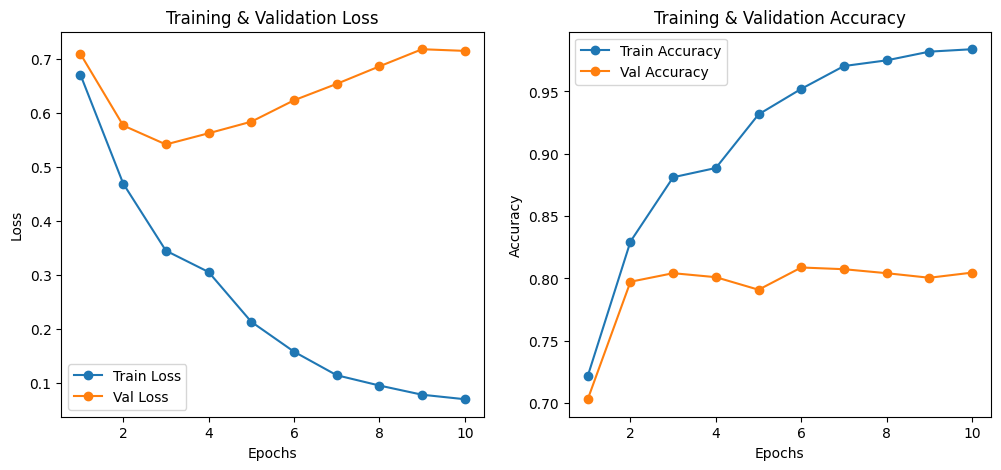

In [155]:
plot_training_progress(history)

In [157]:
# Dự đoán trên tập test
predictions = trainer.predict(dataset["test"])
logits = predictions.predictions
labels = predictions.label_ids
pred_labels = np.argmax(logits, axis=-1)

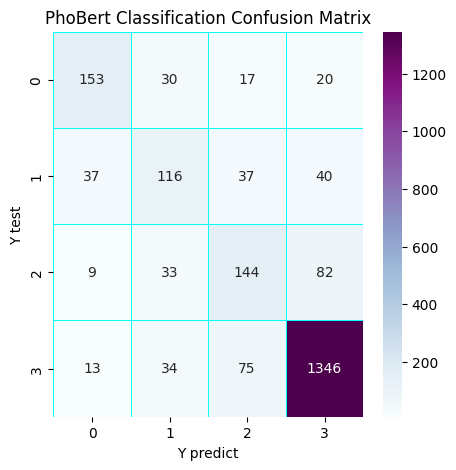

In [158]:
# The confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

pb_val = confusion_matrix(labels, pred_labels)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(pb_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('PhoBert Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

# LSTM

In [159]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from datasets import Dataset
from sklearn.model_selection import train_test_split

In [160]:
pip install -q pyvi

Note: you may need to restart the kernel to use updated packages.


In [161]:
from pyvi import ViTokenizer

In [162]:
def tokenize_text(examples):
    # examples['clean_text'] là danh sách các văn bản trong batch
    tokenized_texts = [ViTokenizer.tokenize(text) for text in examples['clean_text']]
    return {"tokenized_text": tokenized_texts}

In [211]:
train_df, test_df = train_test_split(df_all, test_size=0.2, stratify=df_all['label'], random_state=42)

In [212]:
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [213]:
train_dataset = train_dataset.map(tokenize_text, batched=True)
test_dataset = test_dataset.map(tokenize_text, batched=True)

Map:   0%|          | 0/8744 [00:00<?, ? examples/s]

Map:   0%|          | 0/2186 [00:00<?, ? examples/s]

In [214]:
vocab_size = 5000  
max_length = 128   
embedding_dim = 300  
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_dataset['tokenized_text'])  # Chỉ fit trên tập train
train_sequences = tokenizer.texts_to_sequences(train_dataset['tokenized_text'])
test_sequences = tokenizer.texts_to_sequences(test_dataset['tokenized_text'])

train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

train_labels = np.array(train_dataset['label'])
test_labels = np.array(test_dataset['label'])

num_classes = 4
train_labels = to_categorical(train_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [215]:
from tensorflow.keras import optimizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [216]:
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length, trainable=True),
    Bidirectional(LSTM(256, return_sequences=False)),  # Giảm số units
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),  # Thêm Batch Normalization
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

adam = optimizers.Adam(learning_rate=0.00005)  # Learning rate thấp để ổn định
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)             │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_10 (Bidirectional)     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [217]:
checkpoint = ModelCheckpoint(
    filepath="best_model.keras",
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
    verbose=1
)

In [218]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

In [219]:
history = model.fit(train_padded, 
                    train_labels, 
                    epochs=15, 
                    batch_size=32, 
                    validation_data=(test_padded, test_labels), 
                    verbose = 1,
                    callbacks=[early_stopping,checkpoint,reduce_lr]
                   )

Epoch 1/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3184 - loss: 1.4185
Epoch 1: val_accuracy improved from -inf to 0.69213, saving model to best_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.3186 - loss: 1.4182 - val_accuracy: 0.6921 - val_loss: 1.2771 - learning_rate: 5.0000e-05
Epoch 2/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5330 - loss: 1.1370
Epoch 2: val_accuracy improved from 0.69213 to 0.74794, saving model to best_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.5331 - loss: 1.1368 - val_accuracy: 0.7479 - val_loss: 0.9153 - learning_rate: 5.0000e-05
Epoch 3/15
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6813 - loss: 0.8790
Epoch 3: val_accuracy improved from 0.74794 to 0.75755, saving model to best_model.keras
274/274 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6814 - loss: 0.8788 - val_accuracy: 0.7575 - val_loss: 0.6824 - learning_rate: 5.0000e-05
Epoch 4/15
274/274 ━━━━━━━━━━━━━━━━━

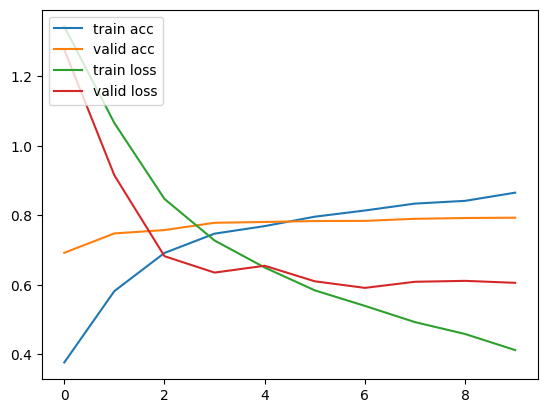

In [220]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train acc', 'valid acc', 'train loss', 'valid loss'], loc = 'upper left')
plt.show()

In [221]:
from tensorflow.keras.models import load_model

model = load_model("best_model.keras")

In [222]:
test_loss, test_acc = model.evaluate(test_padded, test_labels, verbose=1)
print(f"Độ chính xác trên tập test: {test_acc:.4f}")
print("Loss trên tập test:",test_loss)

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7923 - loss: 0.6190
Độ chính xác trên tập test: 0.7932
Loss trên tập test: 0.6056150794029236


In [223]:
y_pred = model.predict(test_padded)

69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [224]:
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_labels

array([3, 3, 3, ..., 1, 3, 2])

In [225]:
y_test_labels = np.argmax(test_labels, axis=1)


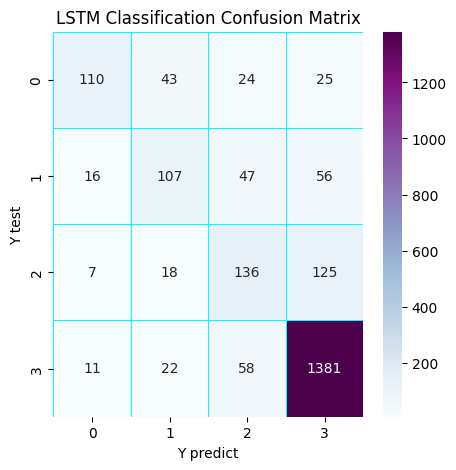

In [226]:
pb_val = confusion_matrix(y_test_labels, y_pred_labels)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(pb_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()